In [42]:
# Import libraries for model training
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score, GridSearchCV
import xgboost as xgb
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay
import pandas as pd
import os
from sklearn.decomposition import PCA

### Define Model Pipelines

In [43]:
def create_model_pipelines():
    """Create a dictionary of model pipelines"""
    pipelines = {}
    
    # XGBoost
    pipelines['xgboost'] = Pipeline([
        ('scaler', StandardScaler()),
        ('model', xgb.XGBClassifier(n_estimators=100, learning_rate=0.1, random_state=42))
    ])
    
    # SVM
    pipelines['svm'] = Pipeline([
        ('scaler', StandardScaler()),
        ('model', SVC(probability=True, random_state=42))
    ])
    
    # Random Forest
    pipelines['random_forest'] = Pipeline([
        ('scaler', StandardScaler()),
        ('model', RandomForestClassifier(n_estimators=100, random_state=42))
    ])
    
    # Neural Network (MLP)
    pipelines['neural_network'] = Pipeline([
        ('scaler', StandardScaler()),
        ('pca', PCA(n_components=0.95)),  # Keep components explaining 95% of variance
        ('model', MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=300, random_state=42))
    ])
    
    # KNN
    pipelines['knn'] = Pipeline([
        ('scaler', StandardScaler()),
        ('model', KNeighborsClassifier(n_neighbors=5))
    ])
    
    # Gradient Boosting
    pipelines['gradient_boosting'] = Pipeline([
        ('scaler', StandardScaler()),
        ('model', GradientBoostingClassifier(n_estimators=100, random_state=42))
    ])
    
    return pipelines

### Training and Evaluation Function

In [44]:
def train_and_evaluate_models(feature_selector='mi'):
    """Train and evaluate multiple models using the specified feature selection method"""
    # Load pre-processed data
    train_df = pd.read_csv(f'processed_data/train_df_{feature_selector}.csv')
    val_df = pd.read_csv(f'processed_data/val_df_{feature_selector}.csv')
    test_df = pd.read_csv(f'processed_data/test_df_{feature_selector}.csv')
    
    # Prepare data
    X_train = train_df.drop(['image_path', 'ClassId'], axis=1)
    y_train = train_df['ClassId']
    
    X_val = val_df.drop(['image_path', 'ClassId'], axis=1)
    y_val = val_df['ClassId']
    
    # For test data, we only need features (no labels)
    X_test = test_df.drop(['image_path'], axis=1)
    if 'ClassId' in test_df.columns:
        X_test = X_test.drop(['ClassId'], axis=1)
    test_image_paths = test_df['image_path']
    
    # Create pipelines
    pipelines = create_model_pipelines()
    
    # Results storage
    results = {
        'model': [],
        'training_time': [],
        'cross_val_score': [],
        'validation_accuracy': []
    }
    
    # Store test predictions for each model
    test_predictions = {}
    
    print(f"Training models with {feature_selector} feature selection")
    print("=" * 80)
    
    # Train and evaluate each model
    for model_name, pipeline in pipelines.items():
        print(f"\nTraining {model_name}...")
        
        # Measure training time
        start_time = time.time()
        
        # Cross-validation
        cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='accuracy')
        print(f"Cross-validation accuracy: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")
        
        # Train on full training set
        pipeline.fit(X_train, y_train)
        training_time = time.time() - start_time
        
        # Evaluate on validation set
        y_val_pred = pipeline.predict(X_val)
        val_accuracy = accuracy_score(y_val, y_val_pred)
        print(f"Validation accuracy: {val_accuracy:.4f}")
        
        # Make predictions on test set (no evaluation since we don't have labels)
        y_test_pred = pipeline.predict(X_test)
        test_predictions[model_name] = y_test_pred
        print(f"Generated predictions for {len(y_test_pred)} test samples")
        
        # Store results
        results['model'].append(model_name)
        results['training_time'].append(training_time)
        results['cross_val_score'].append(cv_scores.mean())
        results['validation_accuracy'].append(val_accuracy)
        
        # Detailed report for validation set
        print("\nClassification Report (Validation Set):")
        print(classification_report(y_val, y_val_pred))
        
        # Plot confusion matrix for validation set
        plt.figure(figsize=(10, 8))
        cm = confusion_matrix(y_val, y_val_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot(cmap='Blues')
        plt.title(f'Confusion Matrix - {model_name} (Validation Set)')
        plt.tight_layout()
        plt.savefig(f'model_results/{model_name}_{feature_selector}_cm.png')
        
        # Save the model
        import joblib
        joblib.dump(pipeline, f'model_results/{model_name}_{feature_selector}_model.pkl')
        
        # Save test predictions for this model
        test_pred_df = pd.DataFrame({
            'image_path': test_image_paths,
            'ClassId': y_test_pred
        })
        test_pred_df.to_csv(f'model_results/{model_name}_{feature_selector}_test_predictions.csv', index=False)
    
    # Create results dataframe
    results_df = pd.DataFrame(results)
    
    # Sort by validation accuracy
    results_df = results_df.sort_values('validation_accuracy', ascending=False)
    
    # Save results
    results_df.to_csv(f'model_results/model_comparison_{feature_selector}.csv', index=False)
    
    # Plot results
    plt.figure(figsize=(12, 6))
    sns.barplot(x='model', y='validation_accuracy', data=results_df)
    plt.title(f'Model Comparison - {feature_selector} Feature Selection')
    plt.ylim(0.5, 1.0)  # Adjust as needed
    plt.tight_layout()
    plt.savefig(f'model_results/model_comparison_{feature_selector}.png')
    
    # Create a submission file using the best model
    best_model = results_df.iloc[0]['model']
    print(f"\nCreating submission file using the best model: {best_model}")
    
    # Read the original test metadata to get the IDs
    test_metadata = pd.read_csv('test/test_metadata.csv')
    
    # Create submission dataframe
    submission_df = pd.DataFrame({
        'id': test_metadata['id'],
        'ClassId': test_predictions[best_model]
    })
    
    # Save submission file
    submission_df.to_csv(f'submission_{feature_selector}.csv', index=False)
    print(f"Submission file saved to submission_{feature_selector}.csv")
    
    return results_df, pipelines, test_predictions 

### Hyperparameter Tuning Function

In [45]:
def tune_best_model(best_model_name, feature_selector='mi'):
    """Perform hyperparameter tuning for the best performing model"""
    # Load pre-processed data
    train_df = pd.read_csv(f'processed_data/train_df_{feature_selector}.csv')
    val_df = pd.read_csv(f'processed_data/val_df_{feature_selector}.csv')
    
    # Combine training and validation for tuning
    combined_df = pd.concat([train_df, val_df], ignore_index=True)
    X = combined_df.drop(['image_path', 'ClassId'], axis=1)
    y = combined_df['ClassId']
    
    # Define parameter grids for each model
    param_grids = {
        'xgboost': {
            'model__n_estimators': [50, 100, 200],
            'model__learning_rate': [0.01, 0.1, 0.2],
            'model__max_depth': [3, 5, 7]
        },
        'svm': {
            'model__C': [0.1, 1, 10, 100],
            'model__gamma': ['scale', 'auto', 0.01, 0.1],
            'model__kernel': ['rbf', 'poly']
        },
        'random_forest': {
            'model__n_estimators': [50, 100, 200],
            'model__max_depth': [None, 10, 20],
            'model__min_samples_split': [2, 5, 10]
        },
        'neural_network': {
            'model__hidden_layer_sizes': [(50,), (100,), (100, 50), (200, 100)],
            'model__alpha': [0.0001, 0.001, 0.01],
            'model__learning_rate': ['constant', 'adaptive']
        },
        'knn': {
            'model__n_neighbors': [3, 5, 7, 9],
            'model__weights': ['uniform', 'distance'],
            'model__p': [1, 2]  # Manhattan or Euclidean distance
        },
        'gradient_boosting': {
            'model__n_estimators': [50, 100, 200],
            'model__learning_rate': [0.01, 0.1, 0.2],
            'model__max_depth': [3, 5, 7]
        }
    }
    
    # Get the pipeline and parameter grid
    pipelines = create_model_pipelines()
    pipeline = pipelines[best_model_name]
    param_grid = param_grids[best_model_name]
    
    print(f"Tuning hyperparameters for {best_model_name}...")
    print("=" * 80)
    
    # Perform grid search
    grid_search = GridSearchCV(
        pipeline,
        param_grid=param_grid,
        cv=5,
        scoring='accuracy',
        verbose=1,
        n_jobs=-1
    )
    
    # Fit the grid search
    grid_search.fit(X, y)
    
    # Report results
    print(f"\nBest parameters: {grid_search.best_params_}")
    print(f"Best cross-validation accuracy: {grid_search.best_score_:.4f}")
    
    # Save the best model
    import joblib
    joblib.dump(grid_search.best_estimator_, 
                f'model_results/{best_model_name}_{feature_selector}_tuned_model.pkl')
    
    # Create a directory for model results if it doesn't exist
    os.makedirs('model_results', exist_ok=True)
    
    return grid_search.best_estimator_, grid_search.best_params_, grid_search.best_score_

### Run Model Training and Evaluation

In [46]:
# Create directories for results
os.makedirs('model_results', exist_ok=True)
os.makedirs('processed_data', exist_ok=True)

Training models with rf feature selection

Training xgboost...
Cross-validation accuracy: 0.7403 ± 0.0094
Validation accuracy: 0.7851
Generated predictions for 2353 test samples

Classification Report (Validation Set):
              precision    recall  f1-score   support

           0       1.00      0.17      0.29         6
           1       0.70      0.77      0.73        62
           2       0.57      0.70      0.63        63
           3       0.79      0.67      0.72        39
           4       0.73      0.78      0.75        55
           5       0.69      0.60      0.64        52
           6       1.00      0.83      0.91        12
           7       0.67      0.72      0.70        40
           8       0.81      0.64      0.71        39
           9       0.75      0.80      0.78        41
          10       0.80      0.91      0.85        56
          11       0.53      0.89      0.67        37
          12       0.97      0.98      0.97        59
          13       1.00 

/Users/xzhou/pyvenvs/ml/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/xzhou/pyvenvs/ml/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/xzhou/pyvenvs/ml/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Training svm...
Cross-validation accuracy: 0.7877 ± 0.0118
Validation accuracy: 0.8142
Generated predictions for 2353 test samples

Classification Report (Validation Set):
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         6
           1       0.70      0.84      0.76        62
           2       0.72      0.70      0.71        63
           3       0.76      0.67      0.71        39
           4       0.73      0.75      0.74        55
           5       0.59      0.65      0.62        52
           6       0.92      0.92      0.92        12
           7       0.72      0.82      0.77        40
           8       0.78      0.64      0.70        39
           9       0.97      0.95      0.96        41
          10       0.90      0.96      0.93        56
          11       0.52      0.86      0.65        37
          12       1.00      1.00      1.00        59
          13       1.00      1.00      1.00        60
          14    

/Users/xzhou/pyvenvs/ml/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/xzhou/pyvenvs/ml/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/xzhou/pyvenvs/ml/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Training random_forest...
Cross-validation accuracy: 0.7569 ± 0.0111
Validation accuracy: 0.7896
Generated predictions for 2353 test samples

Classification Report (Validation Set):
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         6
           1       0.70      0.85      0.77        62
           2       0.60      0.71      0.65        63
           3       0.84      0.67      0.74        39
           4       0.65      0.73      0.68        55
           5       0.68      0.62      0.65        52
           6       0.92      0.92      0.92        12
           7       0.79      0.75      0.77        40
           8       0.92      0.59      0.72        39
           9       0.83      0.85      0.84        41
          10       0.74      0.93      0.83        56
          11       0.48      0.84      0.61        37
          12       0.97      1.00      0.98        59
          13       1.00      1.00      1.00        60
      

/Users/xzhou/pyvenvs/ml/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/xzhou/pyvenvs/ml/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/xzhou/pyvenvs/ml/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Training neural_network...


/Users/xzhou/pyvenvs/ml/lib/python3.11/site-packages/sklearn/decomposition/_pca.py:606: RuntimeWarning: divide by zero encountered in matmul
  C = X.T @ X
/Users/xzhou/pyvenvs/ml/lib/python3.11/site-packages/sklearn/decomposition/_pca.py:606: RuntimeWarning: overflow encountered in matmul
  C = X.T @ X
/Users/xzhou/pyvenvs/ml/lib/python3.11/site-packages/sklearn/decomposition/_pca.py:606: RuntimeWarning: invalid value encountered in matmul
  C = X.T @ X
/Users/xzhou/pyvenvs/ml/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/xzhou/pyvenvs/ml/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/xzhou/pyvenvs/ml/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T


Cross-validation accuracy: 0.8041 ± 0.0102


/Users/xzhou/pyvenvs/ml/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/xzhou/pyvenvs/ml/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/xzhou/pyvenvs/ml/lib/python3.11/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/xzhou/pyvenvs/ml/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/xzhou/pyvenvs/ml/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/xzhou/pyvenvs/ml/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
/Users/xzhou/py

Validation accuracy: 0.8188
Generated predictions for 2353 test samples

Classification Report (Validation Set):
              precision    recall  f1-score   support

           0       0.50      0.33      0.40         6
           1       0.80      0.79      0.80        62
           2       0.66      0.73      0.69        63
           3       0.64      0.72      0.67        39
           4       0.80      0.82      0.81        55
           5       0.63      0.60      0.61        52
           6       1.00      0.92      0.96        12
           7       0.71      0.80      0.75        40
           8       0.86      0.62      0.72        39
           9       0.86      0.93      0.89        41
          10       0.91      0.89      0.90        56
          11       0.62      0.68      0.65        37
          12       0.97      1.00      0.98        59
          13       1.00      0.98      0.99        60
          14       0.91      0.95      0.93        22
          15       0.9

/Users/xzhou/pyvenvs/ml/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/xzhou/pyvenvs/ml/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/xzhou/pyvenvs/ml/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Creating submission file using the best model: neural_network
Submission file saved to submission_rf.csv


<Figure size 1000x800 with 0 Axes>

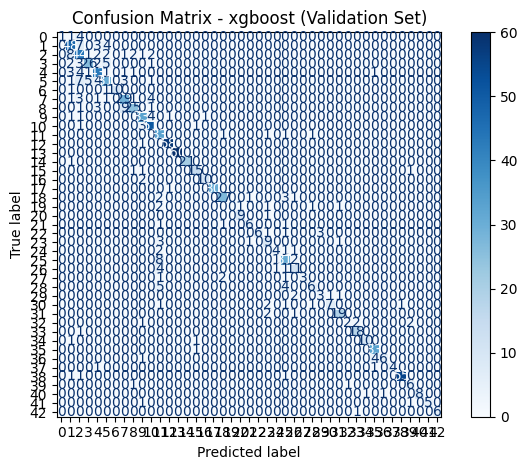

<Figure size 1000x800 with 0 Axes>

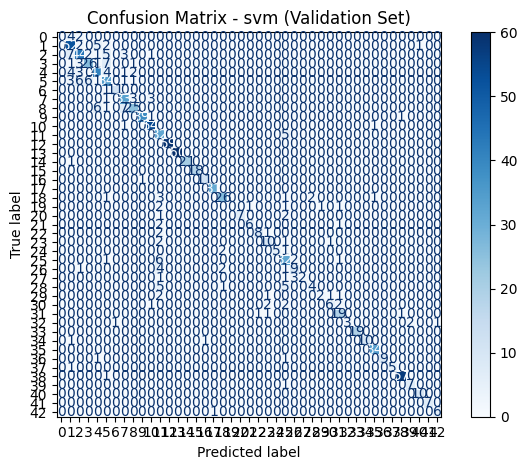

<Figure size 1000x800 with 0 Axes>

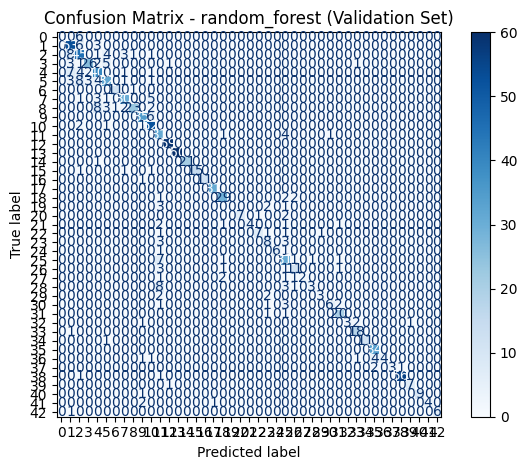

<Figure size 1000x800 with 0 Axes>

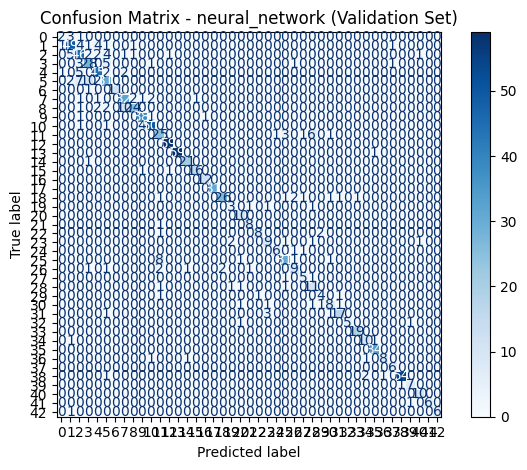

<Figure size 1000x800 with 0 Axes>

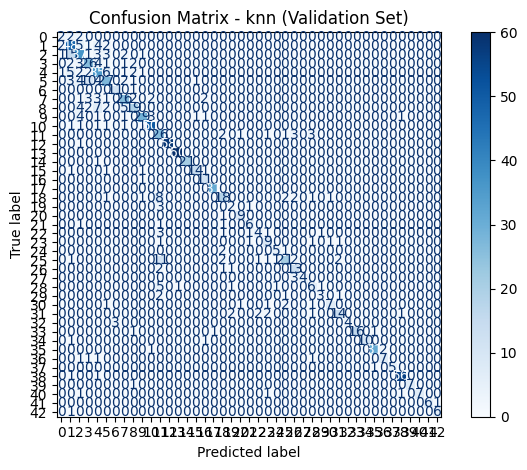

<Figure size 1000x800 with 0 Axes>

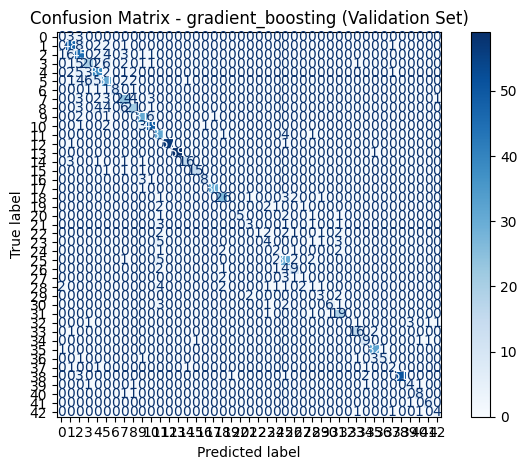

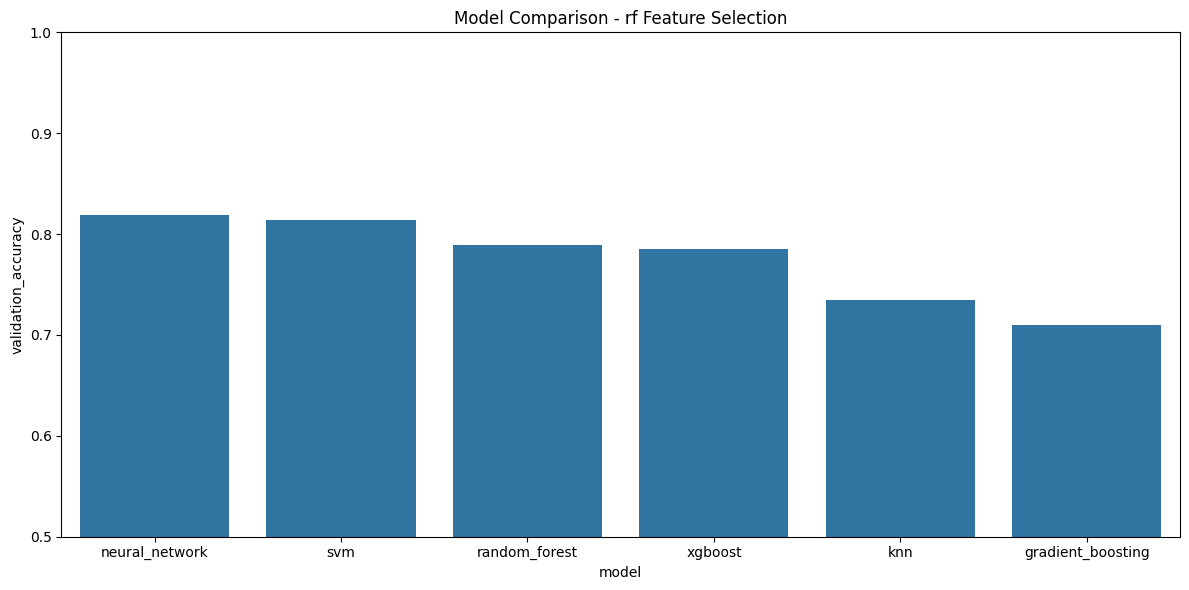

In [47]:
# Run models with Random Forest feature selection
rf_results, rf_pipelines, rf_predictions = train_and_evaluate_models('rf')

# Run models with Lasso feature selection
# lasso_results, lasso_pipelines, lasso_predictions = train_and_evaluate_models('lasso')

# Run models with Mutual Information feature selection
# mi_results, mi_pipelines, mi_predictions = train_and_evaluate_models('mi')

### Tune Best Model

```python
# Example: If XGBoost was the best model with MI feature selection
best_model, best_params, best_score = tune_best_model('xgboost', 'mi')
```